# Approximating Parameterized Advection Diffusion Equation with Various Methods

First import the necessary libraries.

In [13]:
import numpy as np
import math as m
from scipy import linalg
from scipy.sparse import diags
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

Consider the following PDE:
<br>
<br>
$$-\Delta y(x;\theta) + \begin{bmatrix} \theta \\ 0 \end{bmatrix} \nabla y(x;\theta) = 100e^{-5 \sqrt{x_1^2 + x_2^2}}, \quad (x_1, x_2) \in (-1, 1)^2,$$
<br>
with homogeneous Dirichlet boundary conditions.
<br>
<br>
Discretize using finite differences. Set the parameters as the following:
<br>
<br>
$$n_{x_1} = n_{x_2} = 30, \quad (h_1 = h_2 = 2 / 31)$$

In [14]:
nx1 = 30
nx2 = 30

h1 = 2.0 / (nx1 + 1)
h2 = 2.0 / (nx2 + 1)

x1s = np.linspace(-1 + h1, 1 - h1, nx1)
x2s = np.linspace(-1 + h2, 1 - h2, nx2)

Use upwind discretization to get the system:
<br>
<br>
$$A(\theta) y(\theta) = f$$
<br>
with
<br>
<br>
$$A(\theta) = I_{n_2} \otimes (A_1^{diff} + A_1^{conv}(\theta)) + A_2^{diff} \otimes I_{n_1} \in \mathbb{R}^{n_{x_1}n_{x_2} \times n_{x_1}n_{x_2}},$$
<br>
$$A_1^{conv}(\theta) = \frac{max(0, \theta)}{h_1} \begin{bmatrix} 1 &&&&\\ -1&1&&&\\&\ddots&\ddots&&\\&&-1&1&\\&&&-1&1 \end{bmatrix} + \frac{min(0, \theta)}{h_1} \begin{bmatrix} -1&1&&&\\ &-1&1&&\\&&\ddots&\ddots&\\&&&-1&1\\&&&&-1 \end{bmatrix} \in \mathbb{R}^{n_{x_1} \times n_{x_1}}$$
<br>
$$A_i^{diff} = \frac{1}{h_i^2} \begin{bmatrix} 2&-1&&&\\ -1&2&-1\\&\ddots&\ddots&\ddots&\\&&-1&2&-1\\&&&-1&2\end{bmatrix} \in \mathbb{R}^{n_{x_i} \times n_{x_i}}, \quad i=1,2$$
<br>
Write a function to generate $A(\theta)$ for any $\theta$:

In [22]:
def A_diff(h, nx):
    main_diag = 2 * np.ones((nx))
    offset_diag = -1 * np.ones((nx - 1))
    return (1 / h**2) * diags([offset_diag, main_diag, offset_diag], [-1, 0, 1]).toarray()

A1_diff = A_diff(h1, nx1)
A2_diff = A_diff(h2, nx2)

A0 = np.kron(np.eye(nx2), A1_diff) + np.kron(A2_diff, np.eye(nx1))
A1 = np.kron(np.eye(nx2),(1 / h1) * diags([-1 * np.ones((nx1 - 1)), np.ones((nx1))], [-1, 0]).toarray())
A2 = np.kron(np.eye(nx2),(1 / h1) * diags([-1 * np.ones((nx1)), np.ones((nx1 - 1))], [0, 1]).toarray())


def A(theta):
    return A0 + max(0, theta) * A1 + min(0, theta) * A2

Generate the array $f$:

In [23]:
def f_func(x1, x2):
    return 100 * m.exp(-5 * m.sqrt(x1**2 + x2**2))

f_idx = 0
f = np.zeros((nx1 * nx2))

for x2 in x2s:
    for x1 in x1s:
        f[f_idx] = f_func(x1, x2)
        f_idx += 1

Solve for $y(\theta)$ for multiple values of $\theta \in [-10, 10]$:

In [24]:
thetas_train = [i for i in range(-12,13,2)]
thetas_train.remove(0)
thetas_plot = [-10, 0, 10]
Y_fd_snap_train = np.zeros((nx1 * nx2, len(thetas_train)))
Y_fd_snap_plot = np.zeros((nx1 * nx2, len(thetas_plot)))

for idx in range(len(thetas_train)):
    Y_fd_snap_train[:,idx] = linalg.solve(A(thetas_train[idx]), f)
    
for idx in range(len(thetas_plot)):
    Y_fd_snap_plot[:,idx] = linalg.solve(A(thetas_plot[idx]), f)

Plot $y$ at $\theta = -10, 0, 10$:

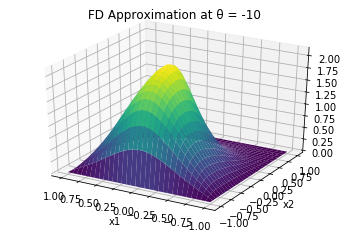

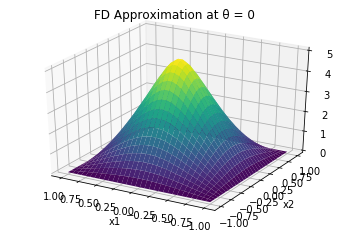

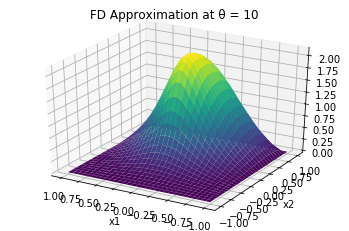

In [25]:
def plot_at_thetas(thetas, snaps, title):
    for snap_idx in range(len(thetas)):
        fig = plt.figure()
        yplot = np.zeros((nx1 + 2, nx2 + 2))
        yplot[1:-1, 1:-1] = np.reshape(snaps[:,snap_idx],(nx1, nx2))
    
        [X1,X2]= np.meshgrid(np.linspace(-1, 1, nx1 + 2), np.linspace(-1, 1, nx2 + 2))
        ax = plt.axes(projection='3d')
        ax.plot_surface(X1, X2, np.transpose(yplot), rstride=1, cstride=1,cmap='viridis',edgecolor='none')
        ax.invert_xaxis()
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title(title + ' at \u03B8 = ' + str(thetas[snap_idx]))
        plt.show()
        
plot_at_thetas([-10, 0, 10], Y_fd_snap_plot, "FD Approximation")

Let $$\bar{y} = \frac{1}{n_\theta} \sum^{n_\theta}_{j=1} y(\theta_j)$$ and $$Y_{adjusted} = Y_{snapshots} - \bar{y}e^T.$$
<br>
Compute the SVD decomposition $Y_{adjusted} = U \Sigma V^T$ and plot the normalized singular values:

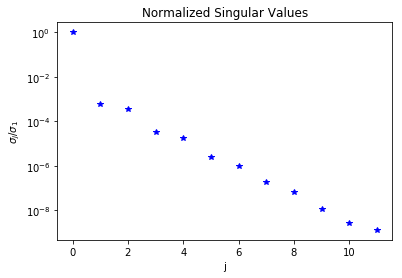

In [26]:
Y_bar = np.mean(Y_fd_snap_train, 1)
Y_adjusted = Y_fd_snap_train - (Y_bar @ np.ones((nx1 * nx2, len(thetas_train))))
U,S,V = linalg.svd(Y_adjusted)

plt.semilogy((1.0 / S[0]) * S, 'b*')
plt.xlabel('j')
plt.ylabel(r'$\sigma_j/\sigma_1$')
plt.title("Normalized Singular Values")
plt.show()


Notice that the singular values decrease rapidly. Choose $k << n_{x_1}n_{x_2}$ such that $\forall \theta \ \exists \widehat{y}(\theta) \in \mathbb{R}^k$ such that $y(\theta) \approx \bar{y} + U_k \widehat{y}(\theta)$. Copying this approximation in the previous system and multiplying by $U_k^T$ yields the following $k \times k$ system:
<br>
$$U_k^T A(\theta) U_k \widehat{y}(\theta) = U_k^T f - U_k^T A(\theta) \bar{y}$$
<br>
Solve the system for $\widehat{y}(\theta)$ and use $y(\theta) \approx \bar{y} + U_k \widehat{y}(\theta)$ to get the POD approximation for $y(\theta)$. The following code calculates the POD approximation of $y(\theta)$. Plots showing the POD approximation as well as the error between the POD and FD approximation are produced. 

Input value for k: 3


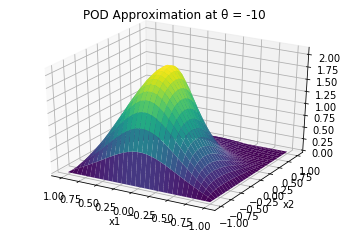

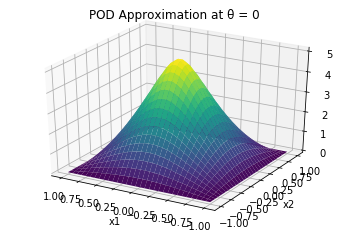

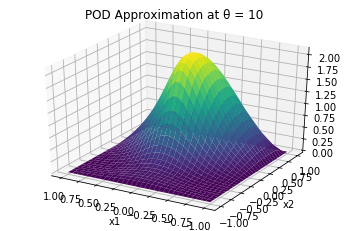

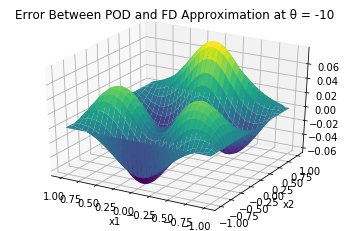

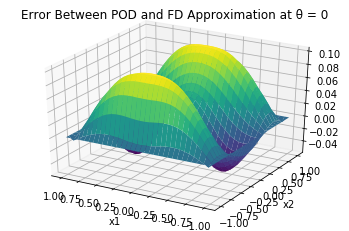

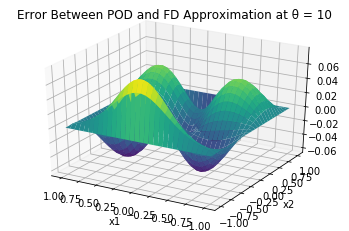

In [30]:
k = input("Input value for k: ")
Uk = U[:, range(int(k))]

Y_pod_snap = np.zeros((nx1 * nx2, len(thetas_plot)))

A0hat = np.transpose(Uk) @ A0 @ Uk
A1hat = np.transpose(Uk) @ A1 @ Uk
A2hat = np.transpose(Uk) @ A2 @ Uk

def Ahat(theta):
    return A0hat + max(0, theta) * A1hat + min(0, theta) * A2hat

fhat0 = np.transpose(Uk) @ f
fhat1 = np.transpose(Uk) @ A0 @ Y_bar
fhat2 = np.transpose(Uk) @ A1 @ Y_bar
fhat3 = np.transpose(Uk) @ A2 @ Y_bar

def fhat(theta):
    return fhat0 - fhat1 - max(0, theta) * fhat2 - min(0, theta) * fhat3

for idx in range(len(thetas_plot)):
    Y_pod_snap[:,idx] = Uk @ linalg.solve(Ahat(thetas_plot[idx]), fhat(thetas_plot[idx])) + Y_bar

plot_at_thetas([-10, 0, 10], Y_pod_snap, "POD Approximation")
    
plot_at_thetas([-10, 0, 10], Y_pod_snap - Y_fd_snap_plot, "Error Between POD and FD Approximation")